# Mapping GOES-16 Data with `Basemap` and `pyproj`
__Brian Blaylock__  
__September 18, 2017__  

__Updated: December 14, 2017__ After GOES-16 moved to east position

This notebook shows how to plot GOES-16 data on a Python Basemap. It also demonstrates a method to project the GOES data on a different map projection, specifically on the HRRR map projection and domain. This is accomplished by calculating the latitude and longitude of every pixel in the GOES image with `pyproj`.

The methods shown here are stitched together from the following useful information I found online:
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](http://proj4.org/projections/geos.html)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)


## Download GOES-16 Data
For this demo, you'll need a GOES-16 data file. I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily download files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/).

To get started, you will need a __CONUS__ file in the __multiband format__. 

http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0

These level 2 files contains all 16 bands on the same 2 km resolution over the contiguous United States. Some additional work, not described here, is needed if you want the full 1 km resolution true color images (i.e. need to download three separate files for each RGB channels and subsample the red channel because of its 0.5 km resolution).

----------

### First, import some libraries we will use

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from netCDF4 import Dataset
import numpy as np
from pyproj import Proj

### Read in the file
The GOES-16 data is in NetCDF format. A description of what the file's name means can be found on [Amazon's page](https://aws.amazon.com/public-datasets/goes/).

In [14]:
# C is for the CONUS NetCDF file
#C_file = 'OR_ABI-L2-MCMIPC-M3_G16_s20172531802165_e20172531804538_c20172531805050.nc' # GOES16 Central
C_file = 'OR_ABI-L2-MCMIPC-M3_G16_s20173481647220_e20173481649593_c20173481650109.nc'  # GOES16 East
C = Dataset(C_file, 'r')

### Get the RGB values for a true color image
I followed the instructions [here](http://edc.occ-data.org/goes16/python/) for applying a gamma correction and calculating the "true green" value.

If needed, you can get the specific wavelengths of each band or channel. For example, `C.variables['band_wavelength_C01'][0]` is the wavelength of channel 1 (visible blue).

In [48]:
# Load the RGB arrays and apply a gamma correction (square root)
R = np.sqrt(C.variables['CMI_C02'][:].data) # Band 2 is red (0.64 um)
G = np.sqrt(C.variables['CMI_C03'][:].data) # Band 3 is "green" (0.865 um)
B = np.sqrt(C.variables['CMI_C01'][:].data) # Band 1 is blue (0.47 um)

# "True Green" is some linear interpolation between the three channels
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Get date information: The midpoint of the begining and ending of the scan time

In [49]:
# Seconds since 2000-01-01 12:00:00
add_seconds = C.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

In [50]:
C.variables['t'][0]

566542120.71903503

We can easliy plot the this image so we can see what it looks like.

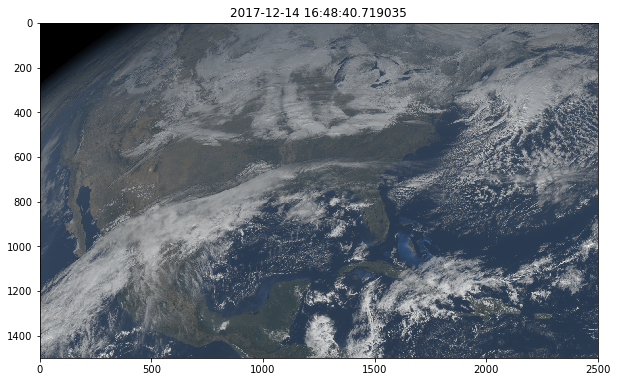

In [51]:
plt.figure(figsize=[10, 8])
plt.imshow(RGB)
plt.title(DATE)

### Plot GOES-16 on a Basemap
The problem with the above image is that it is not georeferenced. We do not know where in the world each pixel lies. The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this data to plot the image on a basemap. The data is in a [geostationary projection](http://proj4.org/projections/geos.html).

In [19]:
C.variables['goes_imager_projection']

<type 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Get a few variables needed to create map projection object and create the pyproj object.

In [20]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

In [40]:
Y.max()

4588198.0

With the projection data, we can plot the satellite imagry on a Basemap.

#### Geostationary Basemap

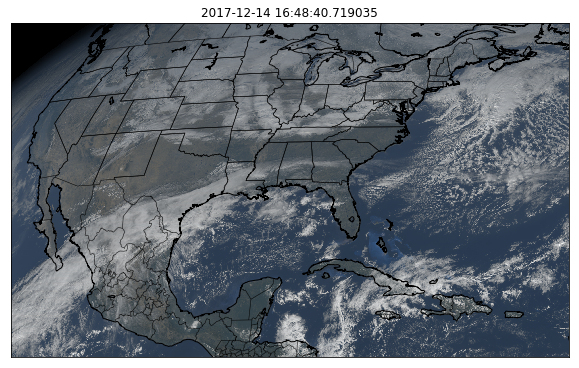

In [42]:
# The geostationary projection is perhaps the easiest way, and we don't need to use the Proj object.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
plt.figure(figsize=[10, 8])
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=1000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title(DATE)

#### Lambert Conformal Projection
To project the GOES-16 data onto a new map we need to get the latitude and longitude of every point in the data. We can do this by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [52]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [53]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

In [54]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

We can't simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [55]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
rgb = np.minimum(rgb, 1) # Force the maximum possible RGB value to be 1 (the lowest should be 0).
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in minimum
  This is separate from the ipykernel package so we can avoid doing imports until


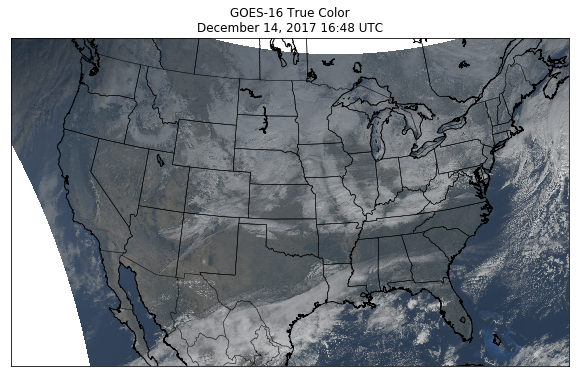

In [56]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color\n%s' % DATE.strftime('%B %d, %Y %H:%M UTC'))

Wa-la! You have just projected the GOES-16 data on the HRRR map projection and domain :)

--------

# HRRR Overlay
Ultimately, I wanted to overlay HRRR analyses over the GOES-16 images. I don't show how I got the HRRR data here, but below is a sample image of HRRR simulated reflectivity and 500 mb heights on September 10, 2017 at 1800 UTC. (If you are interestd in HRRR data, see here: http://hrrr.chpc.utah.edu/)

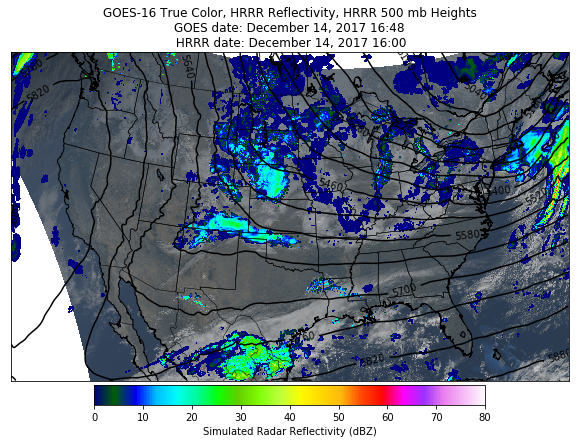

In [35]:
# Load some pre-downloaded HRRR reflectivity data that I have in a numpy dictionary.
H = np.load('HRRR_20171214-1600_REFC.npy').item()

# Load some pre-downloaded HRRR 500 mb heights data that I have in a numpy dictionary.
H500 = np.load('HRRR_20171214-1600_HGT500.npy').item()

# Mask points with no reflectivity
dBZ = H['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ == -10] = np.ma.masked

plt.figure(figsize=[10,8])
# Plot the GOES image
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this, the linewidth is set to zero, but the RGB color is ignored

# Plot the HRRR reflectivity
mH.pcolormesh(H['lon'], H['lat'], dBZ, latlon=True, cmap='gist_ncar', vmax=80, vmin=0)
cb = plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
cb.set_label('Simulated Radar Reflectivity (dBZ)')

# Plot the HRRR 500 mb height
cs = mH.contour(H500['lon'], H500['lat'], H500['value'], latlon=True, colors='k', levels=range(4980, 6100, 60))
plt.clabel(cs, fmt = '%1.0f')

# Plot other map elements
mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

# Title
date_fmt = '%B %d, %Y %H:%M'
plt.title('GOES-16 True Color, HRRR Reflectivity, HRRR 500 mb Heights\nGOES date: %s\n HRRR date: %s' % (DATE.strftime(date_fmt), H['valid'].strftime(date_fmt)))

# Can we do this for a Mesoscale scan?? Yes. Yes we can.

In [15]:
# M1 is for the Mesoscale1 NetCDF file
M1_file = 'OR_ABI-L2-MCMIPM1-M3_G16_s20172531800245_e20172531800302_c20172531800373.nc'
M1 = Dataset(M1_file, 'r')

# Load the RGB arrays and apply a gamma correction (square root)
R = np.sqrt(M1.variables['CMI_C02']) # Band 2 is red (0.64 um)
G = np.sqrt(M1.variables['CMI_C03']) # Band 3 is "green" (0.865 um)
B = np.sqrt(M1.variables['CMI_C01']) # Band 1 is blue (0.47 um)

# "True Green" is some linear interpolation between the three channels
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# Seconds since 2000-01-01 12:00:00
add_seconds = M1.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = M1.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = M1.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = M1.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = M1.variables['x'][:] * sat_h
Y = M1.variables['y'][:] * sat_h

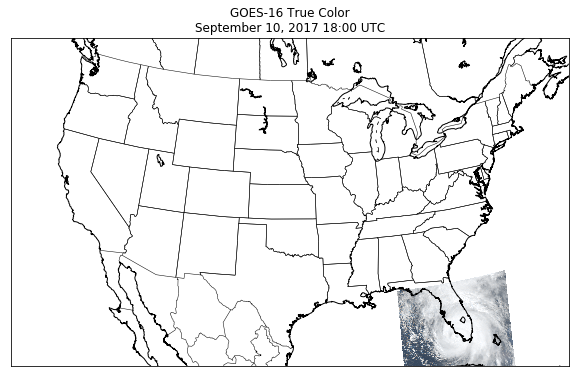

In [16]:
# Plot on HRRR domain:

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
rgb = np.minimum(rgb, 1) # Force the maximum possible RGB value to be 1 (the lowest should be 0).
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color\n%s' % DATE.strftime('%B %d, %Y %H:%M UTC'))

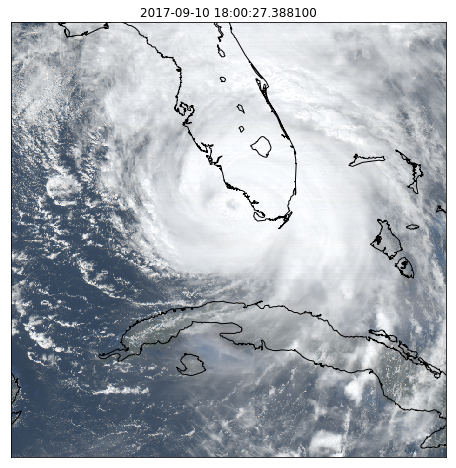

In [17]:
# The geostationary projection
plt.figure(figsize=[10, 8])
m = Basemap(projection='geos', lon_0='-89.5', resolution='i',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title(DATE)

# Can we do this for a Full Disk Scan? It's possible...
but I don't need to do that. Since the data files are so large, plotting anythig is very slow.

In [18]:
# F is for the Full Disk NetCDF file
F_file = 'OR_ABI-L2-MCMIPF-M3_G16_s20172531745358_e20172531756131_c20172531756202.nc'
F = Dataset(F_file, 'r')

# Load the RGB arrays and apply a gamma correction (square root)
R = np.sqrt(F.variables['CMI_C02']) # Band 2 is red (0.64 um)
G = np.sqrt(F.variables['CMI_C03']) # Band 3 is "green" (0.865 um)
B = np.sqrt(F.variables['CMI_C01']) # Band 1 is blue (0.47 um)

# "True Green" is some linear interpolation between the three channels
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [19]:
# Seconds since 2000-01-01 12:00:00
add_seconds = F.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = F.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = F.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = F.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = F.variables['x'][:] * sat_h
Y = F.variables['y'][:] * sat_h

##### Geostationary projection is easy

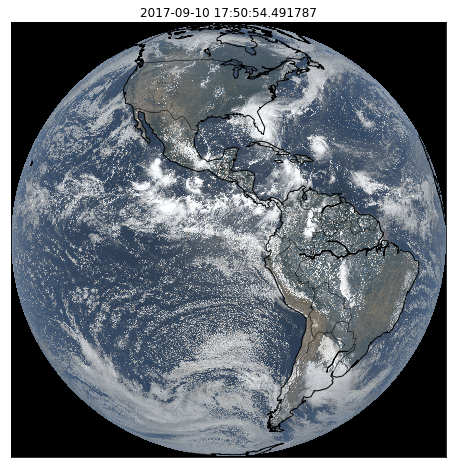

In [20]:
# The geostationary projection
plt.figure(figsize=[10, 8])
m = Basemap(projection='geos', lon_0='-89.5',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
plt.title(DATE)

##### Calculating latitude and longitude of each point is easy with `pyproj`
But you need to mask out the black spaces.

In [21]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
lons, lats = p(XX, YY, inverse=True)

In [22]:
# Mask out the black data
lons = np.ma.array(lons)
lons[lons == 1e30] = np.ma.masked

lats = np.ma.array(lats)
lats[lats == 1e30] = np.ma.masked

In [23]:
# Create a color tuple for pcolormesh
## !! I had to remove the -1 in the line below to get the shape right. I don't know why.
rgb = RGB[:,:,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
rgb = np.minimum(rgb, 1) # Force the maximum possible RGB value to be 1 (the lowest should be 0).
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
#colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in minimum
  after removing the cwd from sys.path.


## Beyond this step, I haven't been too successful becuase of lack of memory.

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\colors.py:233: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\colors.py:233: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


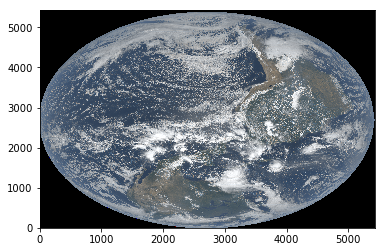

In [24]:
plt.pcolormesh(R, color=colorTuple)